# Results from WandB


## Imports

In [1]:
from community.utils.plotting import set_style
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
import json
import seaborn as sns
import pandas as pd
import numpy.linalg as LA
from itertools import product
import ipywidgets as widgets
import os

In [2]:
from community.utils.heatmap import compute_and_plot_heatmap, compute_and_plot_colormesh
from community.data.datasets.mnist import estimate_covariance

In [3]:
%load_ext autoreload
%autoreload 2

## Load Results

In [6]:
local_save = True

sweep_id = "235k50d1"
sweep_id = "nzpaduwv"
sweep_id = "ug7v2a72"

if not local_save:

    try:
        total_data = pd.read_pickle(f"../../results/sweep_tables/{sweep_id}")
    except FileNotFoundError:
        total_data = pd.read_pickle(
            f"../../results/sweep_tables/MetricResults_{sweep_id}"
        )
else:
    try:
        total_data = pd.read_pickle(
            f"/mnt/storage/gb21/community/compiled_wandb_results/{sweep_id}/metric_table"
        )
    except FileNotFoundError:
        total_data = pd.read_pickle(
            f"/mnt/storage/gb21/community/compiled_wandb_results/{sweep_id}/metric_table_safe"
        )
p = total_data["sparsity"]
total_data["q_metric"] = 0.5 * (1 - p) / (1 + p)
total_data["n_conns"] = (
    (total_data["n_hidden"] ** 2 * total_data["sparsity"]).round().astype(int)
)
total_data

metrics = [
    "retraining_det_col_norm",
    "ablations_det_col_norm",
    "correlations_det_col_norm",
]
new_names = {m: m.split("_")[0] for m in metrics}
metrics = [m.split("_")[0] for m in metrics]
total_data.rename(columns=new_names, inplace=True)

total_data["mean_metric"] = total_data[metrics].mean(1)
# total_data['covariance'] = 1 / total_data['cov_ratio']
total_data["n_classes"] = [
    {"double_digits": 10, "double_letters": 16}[d] for d in total_data["data_type"]
]

try : 

    covariances = {}
    for n in total_data["n_classes"].unique():
        for c in total_data["cov_ratio"].unique():
            covariances[n, c] = estimate_covariance(c, int(n))
    total_data["covariance"] = [
        covariances[n, c] for c, n in total_data[["cov_ratio", "n_classes"]].values
    ]
    total_data["covariance"] = total_data["covariance"].abs()
    total_data['covariance'].min()
except KeyError : 
    pass

#total_data['covariance'] = np.maximum(total_data['covariance'], 1e-4)
#total_data = total_data[total_data['best_acc'] > 0.75]

In [7]:
sparsities = lambda n: np.concatenate(
    [
        np.array([0]),
        (np.geomspace(1, n**2, 30, endpoint=True, dtype=int) / n**2).round(4),
    ]
)


s_index = lambda n, s: sparsities(n).tolist().index(s)
s_indexs = {}
for n in total_data["n_hidden"].unique():
    for s in total_data[total_data["n_hidden"] == n]["sparsity"].unique():
        s_indexs[n, s] = s_index(n, s)
total_data["s_index"] = [
    s_indexs[n, s] for s, n in total_data[["sparsity", "n_hidden"]].values
]

q_metrics = lambda n : 0.5 * (1 - sparsities(n))/(1+sparsities(n))
q_index = lambda n, s: q_metrics(n).tolist().index(s)
q_indexs = {}
for n in total_data["n_hidden"].unique():
    for s in total_data[total_data["n_hidden"] == n]["q_metric"].unique():
        q_indexs[n, s] = q_index(n, s)
total_data["q_index"] = [
    q_indexs[n, s] for s, n in total_data[["q_metric", "n_hidden"]].values
]

In [17]:
def single_filter(data, key, value) : 
    if value is None:
        return data[key].isnull()
    else:
        return data[key] == value

def filter_data(data, v_params):
    data = data.copy()
    for key, value in v_params.items():
        if isinstance(value, list):
            filter = np.sum([single_filter(data, key, value) for v in value], axis=0).astype(bool)
            data = data[filter]
        else:
            if value is None:
                data = data[single_filter(data, key, value)]
            else:
                data = data[single_filter(data, key, value)]

    return data


def get_values(data, x="n_hidden", y="sparsity", value="retraining_global_diff"):
    return data[[x, y, value]].values.T


def get_all_v_params(varying_params, excluded_params={}):
    return [
        {
            k: p
            for k, p in zip(varying_params.keys(), params)
            if k not in excluded_params
        }
        for params in product(*varying_params.values())
    ]


params = [
    "data_type",
    "task",
    "common_readout",
    "common_input",
    "n_bot",
    "covariance",
    "Step",
    'nb_steps',
    'comms_start',
]


varying_params = {}
for param in params:
    if param in total_data.columns:
        varying_params[param] = total_data[param].unique().tolist()
        try:
            varying_params[param] = sorted(varying_params[param])
            varying_params[param] = [
                v if not np.isnan(v) else None for v in varying_params[param]
            ]
        except TypeError:
            pass


heatmap_params = ["n_hidden", "sparsity", "cov_ratio", "n_conns"]

try:
    varying_params["cov_ratio"] = varying_params["cov_ratio"][::-1]
    # varying_params['Step'] = varying_params['Step'][::-1]
except KeyError:
    pass

In [18]:
total_data["mult"] = total_data["retraining_global_diff"] * total_data["best_acc"]

## Plot Interactive Sweep Results

In [21]:
varying_params_all = get_all_v_params(varying_params)


def plot_fn(**params):

    plot_type = params.pop("plot_type")
    metrics = params.pop("metric_to_plot")
    smoothness_x = params.pop("smoothness_x")
    smoothness_y = params.pop("smoothness_y")

    log_scale_x = params.pop("log_scale_x")
    log_scale_y = params.pop("log_scale_y")
    log_scale = [log_scale_x, log_scale_y]
    x, y = params.pop("x"), params.pop("y")

    use_mean = plot_type == 'scipy'

    v_params = {k: v for k, v in params.items()}
    print(v_params)
    # print(v_params)
    excluded_params = {"Step", "task"}
    v_params_filered = {k: v for k, v in params.items() if k not in excluded_params}
    legend_params = {k: v for k, v in v_params_filered.items() if len(v) != 1}

    tasks, steps = v_params["task"], v_params["Step"]

    n_tasks = len(tasks)
    n_steps = len(steps)
    n_metrics = len(metrics)

    v_params_all = get_all_v_params(v_params_filered)
    legend_params_all = get_all_v_params(legend_params)

    for s, step in enumerate(steps):

        v_p1 = len(v_params_filered)
        v_p2 = max([len(v) for v in v_params_filered.values()])

        n_params = len(v_params_all)
        n1 = min(int(np.sqrt(n_params)), 4)
        n2 = n_params // n1

        if n1 * n2 < n_params:
            n2 += 1

        # print(n1, n2)

        fig = plt.figure(
            constrained_layout=True, figsize=(5 * n2 , 5 * n1 * n_tasks * n_metrics)
        )

        fig.suptitle(f"Functional Specialization on step {step}")

        # create 3x1 subfigs
        subfigs = fig.subfigures(nrows=n_metrics, ncols=n_tasks)
        if n_tasks == 1:
            subfigs = np.array([subfigs])

        Zs = []

        for t, (subfigs_m, task) in enumerate(zip(subfigs, tasks)):

            if n_tasks == 1 and n_metrics == 1:
                subfigs_m = np.array([subfigs_m])

            for m, (metric, subfig) in enumerate(zip(metrics, subfigs_m)):

                subfig.suptitle(f"Metric :  {metric}")

                # create subplots per subfig

                axs = subfig.subplots(nrows=n1, ncols=n2)

                try:
                    axs[0]
                except TypeError:
                    axs = np.array([axs])
                for i, (ax, v_param, l_param) in enumerate(
                    zip(axs.flatten(), v_params_all, legend_params_all)
                ):

                    filter_param = v_param.copy()
                    filter_param["Step"] = step
                    filter_param["task"] = task
                    data = filter_data(
                        total_data[total_data["sparsity"] != 0], filter_param
                    )
                    print(data.shape)

                    argmins = (
                        data[metric].values.argsort()[:10],
                        data[metric].values.argsort()[-10:],
                    )
                    minmax = [data[metric].values[idxs].mean() for idxs in argmins]
                    # print(minmax)
                    # print(data.shape)
                    if use_mean : 
                        values = get_values(data.groupby([x, y], as_index=False).mean(numeric_only=True),  x, y, metric)
                    else : 
                        values = get_values(data,  x, y, metric)

                    if 0 not in data.shape:
                        if plot_type == "heatmap":

                            (
                                (X, Y),
                                (X_mesh, Y_mesh),
                                Z,
                                sigmas,
                                *_,
                            ) = compute_and_plot_heatmap(
                                values,
                                (fig, ax),
                                log_scale=log_scale,
                                plot_f=False,
                                random=False,
                                minmax=None,
                                smoothness=[smoothness_x, smoothness_y],
                            )
                        elif plot_type == "scipy":
                            (
                                X_mesh,
                                Y_mesh,
                                Z,
                                (fig, ax),
                                cbar,
                            ) = compute_and_plot_colormesh(
                                values, (fig, ax), log_scale=log_scale
                            )

                        elif plot_type == "table":

                            grouped_values = data.groupby([x, y])[metric].mean()

                            x_values = data[x].unique()[::-1]
                            y_values = data[y].unique()
                            y_values_per_x = data.groupby(x)[y].unique()

                            # Z = np.array([[grouped_values[x][y] for y in y_values_per_x[x]] for x in x_values]).T
                            Z = pd.concat([grouped_values[x] for x in x_values], axis=1)
                            Z.columns = x_values

                            # print(Z)

                            im = ax.imshow(Z)
                            ax.set_xticks(range(len(x_values)))
                            ax.set_xticklabels(x_values.astype(str))
                            if y == "cov_ratio":
                                ax.set_yticks(range(len(y_values)))
                                ax.set_yticklabels(y_values.astype(str))
                            ax.set_xlabel(x)
                            ax.set_ylabel(y)
                            fig.colorbar(im, ax=ax)

                        Zs.append(Z)

                    ax.set_title((str(l_param).strip("{}").replace(",", "\n")))


In [22]:
params_widgets = {
    k: widgets.SelectMultiple(
        options=[p for p in params],
        description=k,
        disabled=False,
        value=[params[1]] if k == "Step" else [params[0]],
        auto_display=False,
    )
    for k, params in varying_params.items()
    if (len(params) > 1 or k == "task")
}

params_widgets["smoothness_x"] = widgets.FloatSlider(
    3, min=0.5, max=10, step=0.2, auto_display=False
)
params_widgets["smoothness_y"] = widgets.FloatSlider(
    6, min=0.5, max=10, step=0.2, auto_display=False
)

# params_widgets['epoch'] = widgets.IntSlider(nb_epochs-1, min=0, max=nb_epochs-1)
params_widgets["log_scale_x"] = widgets.Dropdown(
    options=[False, True], auto_display=False
)
params_widgets["log_scale_y"] = widgets.Dropdown(
    options=[False, True], auto_display=False
)

params_widgets["plot_type"] = widgets.Dropdown(
    options=["heatmap", "scipy", "table"],
    description="Plot Type",
    disabled=False,
    manual=True,
    auto_display=False,
)

params_widgets["metric_to_plot"] = widgets.SelectMultiple(
    options=metrics
    + [
        "best_acc",
        "mult",
        "mean_metric",
    ],
    description="Metric to plot",
    disabled=False,
    manual=True,
    auto_display=False,
    value=[metrics[0]],
)

params_widgets["x"] = widgets.Dropdown(
    options=heatmap_params[:-1],
    description="x-axis",
    disabled=False,
    manual=True,
    auto_display=False,
)

params_widgets["y"] = widgets.Dropdown(
    options=heatmap_params[1:],
    description="y-axis",
    disabled=False,
    manual=True,
    auto_display=False,
)

interactive_plot = widgets.interact_manual(plot_fn, **params_widgets)

interactive(children=(SelectMultiple(description='data_type', index=(0,), options=('double_digits', 'double_le…

In [85]:
display(interactive_plot)

<function __main__.plot_fn(**params)>

## Paper Figures

### Heatmap

### filters

In [11]:
from community.utils.heatmap import (
    movingaverage,
    plot_filters,
    gaussian_filter,
    filter_nans,
    weighted_average,
)


(2, 100)


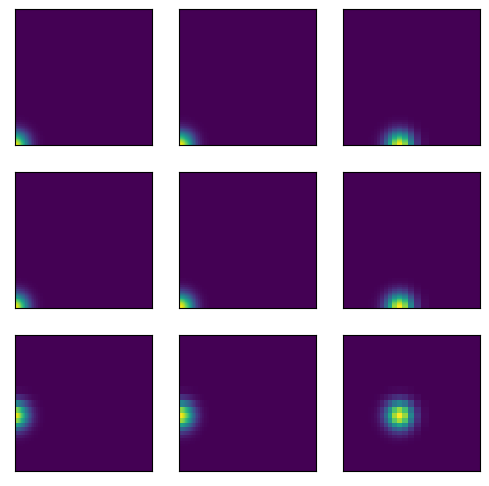

In [24]:
log_space = True

if log_space:
    Y = np.geomspace(1e-4, 1, 100)
    X = np.geomspace(1e-2, 100, 100)
else:
    Y = np.linspace(1e-4, 1, 100)
    X = np.linspace(1e-2, 100, 100)

Xm, Ym = np.meshgrid(X, Y)

ratio = X / Y
# ratio = Xm / Ym

sigmas = np.stack([ratio, np.ones_like(ratio)]) * 0.1
print(sigmas.shape)
points = [10, 50, 90]

all_points = [(p1, p2) for p1 in points for p2 in points]

fig, axs = plt.subplots(
    len(points), len(points), figsize=(2 * len(points), 2 * len(points))
)

for (p1, p2), ax in zip(all_points, axs.T.flatten()):

    point = [X[p1], Y[p2]]

    filter = lambda x, y, s: gaussian_filter(
        (x - point[0]), y - point[1], sigmas=s
    ).sum()

    Z = np.array(
        [[filter(x, y, sigmas[:]) for p1, x in enumerate(X)] for p2, y in enumerate(Y)]
    )
    ax.pcolor(X, Y, Z)

    ax.set_xticks([])
    ax.set_yticks([])

    if log_space:
        # ax.set_xscale('log')
        # ax.set_yscale('log')
        continue


### figure

In [12]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.model_selection import train_test_split

(58405, 38)
(60370, 38)
(61240, 38)
(63525, 38)


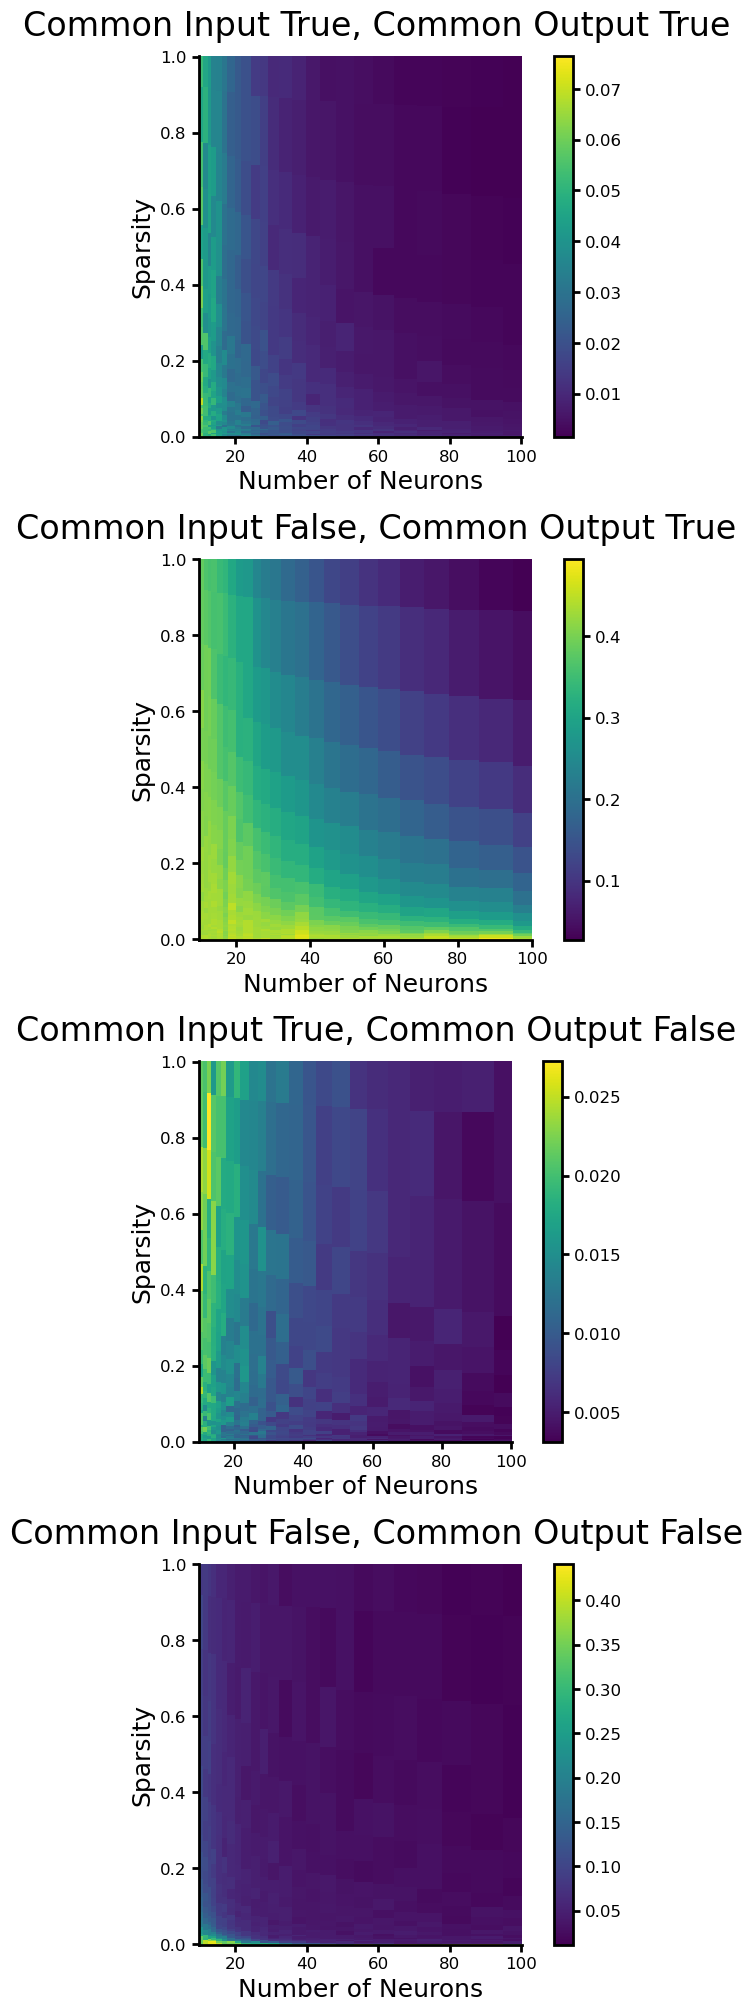

In [15]:
set_style()

plot_type = "scipy"
log_scale = [False, False]
use_mean = plot_type == 'scipy'
do_poly_fit = False 

metrics = [
    "retraining",
    # "correlations_det_col_norm",
    # "ablations_det_col_norm",
]

# metrics = ['mean_global_diff']

fig = plt.figure(constrained_layout=True, figsize=(len(metrics) * 5 * (1 + do_poly_fit), 5 * 4))

# fig.suptitle('Metrics Slices')
subfigs = fig.subfigures(nrows=4, ncols=1)
try:
    subfigs[0]
except TypeError:
    subfigs = [subfigs]

for m, (subfig, [c_r, c_i]) in enumerate(
    zip(subfigs.flatten(), product([True, False], repeat=2))
):
    # for m, subfig in enumerate(subfigs):
    axs = subfig.subplots(nrows=len(metrics), ncols=1 + do_poly_fit)

    try:
        axs[0]
    except TypeError:
        axs = np.array([axs])

    c_data = filter_data(
        total_data,
        {
            "Step": "last",
            "common_input": c_i,
            "common_readout": c_r,
            "n_bot": None,
            "task": ["parity-digits-both", "family"][0],
            #"covariance": varying_params["covariance"],
            'data_type' : 'double_digits'
        },
    )

    if 0 in c_data.shape:
        continue

    subfig.suptitle(f"Common Input {c_i}, Common Output {c_r}")

    c_data = c_data[c_data["sparsity"] != 0]
    print(c_data.shape)

    x_label = "n_hidden"
    y_label = 'sparsity'

    for m, (ax, (metric, poly_fit)) in enumerate(
        zip(axs.flatten(), product(metrics, [False] + [True]*do_poly_fit))
    ):

        if use_mean : 
            values = get_values(c_data.groupby([x_label, y_label], as_index=False).mean(numeric_only=True), x_label, y_label, metric)
        else : 
            values = get_values(c_data, x_label, y_label, metric)

        if y_label == 'n_conns' : 
            values[1] = np.sqrt(values[1])

        if poly_fit : 
            poly = PolynomialFeatures(degree=2)
            X, y = values[:2].T, values[-1]
            X_poly = poly.fit_transform(X)
            X_poly = np.concatenate([X_poly, 1/X_poly[:, 1:]], -1)

            clf = linear_model.LinearRegression()
            clf.fit(X_poly, y)
            y_poly = clf.predict(X_poly)
            values = np.stack([*X.T, y_poly ])
            print(clf.score(X_poly, y))

        # values[1] = np.sqrt(values[1])

        if plot_type == "heatmap":

            ((X, Y), (X_mesh, Y_mesh), Z, sigmas, *_,) = compute_and_plot_heatmap(
                values,
                (fig, ax),
                log_scale=log_scale,
                plot_f=False,
                random=True,
                smoothness=[5, 10],
                minmax=None,
            )

        elif plot_type == "scipy":
            (   (X, Y),
                (X_mesh,
                Y_mesh),
                Z,
                (fig, ax),
                cbar,
            ) = compute_and_plot_colormesh(values, (fig, ax), log_scale=log_scale, resolution=300, method='nearest')

        #ax.set_xlabel(x)
        #ax.set_ylabel(y)
        if y_label == 'n_conns' : 
            ax.set_ylabel('sqrt(synapses)')
        elif y_label == 'sparsity' : 
            ax.set_ylabel('Sparsity')

        # ax.set_title(metrics[i])

        # ax.set_ylabel("Sparsity of Connections")
        # ax.set_yticklabels(ax.get_yticklabels()[::-1])
        ax.set_xlabel("Number of Neurons")

In [ ]:
cicr = filter_data(total_data, {
            "Step": "last",
            "common_input": False,
            "common_readout": True,
            "n_bot": 5,
            "task": ["parity-digits-both", "family"][0],
            "cov_ratio": 1.,
        })

cicr = cicr[cicr['best_acc'] > 0.8]
cicr['ablations'].max()

1.0227254629135132

(34695, 36)
(34655, 36)
(34390, 36)
(34615, 36)


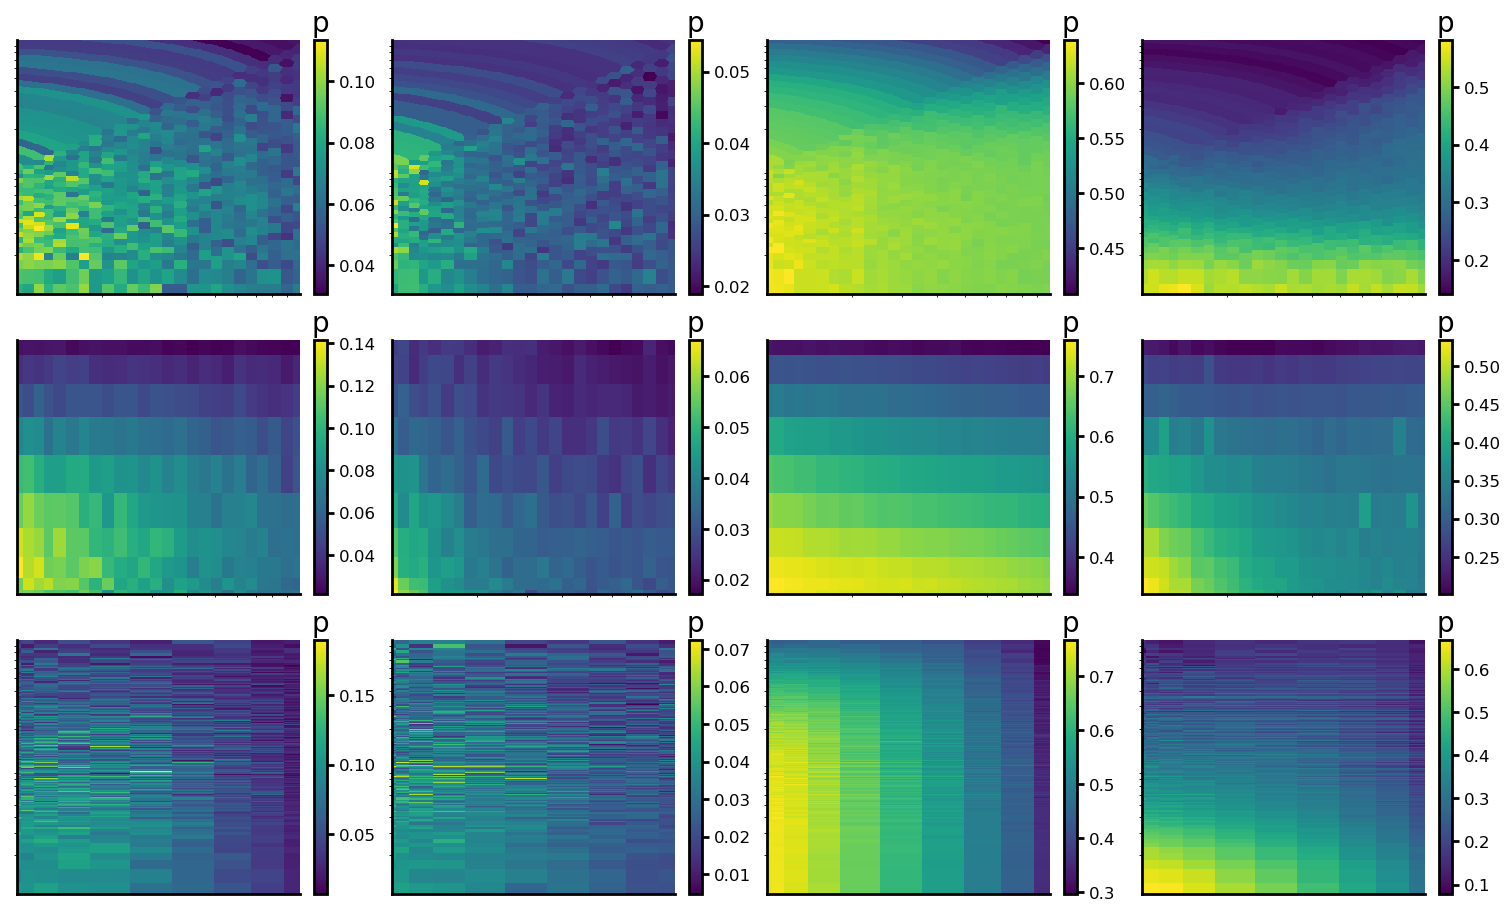

In [ ]:
plots = ["scipy"]
plot_type = plots[0]
use_mean = plot_type == "scipy"
log_scale = False
metric = "mean_metric"

set_style()


fig, axs_m = plt.subplots(3, 4, figsize=(5 * 3, 3 * 3), constrained_layout=True)

for (ci, cr), axs in zip(product([True, False], repeat=2), axs_m.T):
    # plot_type = "heatmap"
    c_data = filter_data(
        total_data,
        {
            "Step": "last",
            "common_input": ci,
            "common_readout": cr,
            "n_bot": None,
            "task": ["parity-digits-both", "family"][0],
            "data_type": "double_letters",
        },
    )

    print(c_data.shape)
    assert 0 not in c_data.shape

    c_data = c_data[c_data["sparsity"] != 0]

    ticks = {
        "n_hidden": [10, 100],
        "sparsity": [0, 1],
        "covariance": [c_data["covariance"].min(), c_data["covariance"].max()],
        "n_conns": [1, np.sqrt(c_data["n_conns"].max())],
    }

    ticks_label = {
        "n_hidden": [10, 100],
        "sparsity": [0, 1],
        "covariance": [0, 1],
        "n_conns": [1,'Full'],
    }

    # if len(plots) == 1:
    #     axs_t = np.array([axs_t])
    # else:
    #     axs_t = axs_t.T

    # for axs, plot_type in zip(axs_t, plots):

    for m, (ax, x, y, s, log) in enumerate(
        zip(
            axs,
            ["n_hidden" , "n_hidden", "covariance"],
            ["n_conns" , "covariance", "n_conns"],
            # [1/30, [1/30, 1/20], [1/30, 1/20]],
            [[3, 20], [3, 20], 0.1],
            [[True, True], [True, False], [False, True]]
        )
    ):
        if use_mean:
            values = get_values(
                c_data.groupby([x, y], as_index=False).mean(numeric_only=True),
                x,
                y,
                metric,
            )
        else:
            values = get_values(c_data, x, y, metric)

        if y == "n_conns":
            values[1] = np.sqrt(values[1])

        if plot_type == "heatmap":
            ((X, Y), (X_mesh, Y_mesh), Z, sigmas, *_, cbar) = compute_and_plot_heatmap(
                values,
                (fig, ax),
                log_scale=log_scale,
                plot_f=False,
                random=True,
                smoothness=s,
                minmax=None,
                cbar=True,
                plot=True,
            )

        elif plot_type == "scipy":
            (
                (X, Y),
                (X_mesh, Y_mesh),
                Z,
                (fig, ax),
                cbar,
            ) = compute_and_plot_colormesh(
                values, (fig, ax), log_scale=log, minmax=None, random=False, imshow=False
            )

        ax.set_xlabel(x)
        ax.set_ylabel(y)

        ax.set_xlabel("")
        ax.set_ylabel("")

        try:
            cbar.set_label("p")
        except AttributeError:
            pass

        # ax.set_xticks(ticks[x])
        # ax.set_yticks(ticks[y])

        ax.set_xticks([])
        ax.set_yticks([])

        # ax.set_xticklabels(ticks_label[x])
        # ax.set_yticklabels(ticks_label[y])

        ax.set_xticklabels('')
        ax.set_yticklabels('')


In [175]:
c_data['covariance'].unique()

array([0.85802391, 0.66297706, 0.11140853, 0.05312799, 0.19158779,
       0.55429589, 0.03076751, 0.76768192, 0.42014766, 0.3011768 ])

In [172]:
X_mesh[0]

array([0.03076751, 0.03353426, 0.036301  , 0.03906774, 0.04183449,
       0.04460123, 0.04736798, 0.05013472, 0.05290146, 0.05566821,
       0.05843495, 0.06120169, 0.06396844, 0.06673518, 0.06950193,
       0.07226867, 0.07503541, 0.07780216, 0.0805689 , 0.08333564,
       0.08610239, 0.08886913, 0.09163588, 0.09440262, 0.09716936,
       0.09993611, 0.10270285, 0.1054696 , 0.10823634, 0.11100308,
       0.11376983, 0.11653657, 0.11930331, 0.12207006, 0.1248368 ,
       0.12760355, 0.13037029, 0.13313703, 0.13590378, 0.13867052,
       0.14143726, 0.14420401, 0.14697075, 0.1497375 , 0.15250424,
       0.15527098, 0.15803773, 0.16080447, 0.16357121, 0.16633796,
       0.1691047 , 0.17187145, 0.17463819, 0.17740493, 0.18017168,
       0.18293842, 0.18570517, 0.18847191, 0.19123865, 0.1940054 ,
       0.19677214, 0.19953888, 0.20230563, 0.20507237, 0.20783912,
       0.21060586, 0.2133726 , 0.21613935, 0.21890609, 0.22167283,
       0.22443958, 0.22720632, 0.22997307, 0.23273981, 0.23550

In [165]:
xticks = ax.yaxis.get_minor_ticks()
xticks[0].label1.set_visible(False)
xticks[-1].label1.set_visible(False)

In [154]:
fig.savefig("../../results/imgs/heatmaps_all.svg")

### Q Metric

In [7]:
uniques = sorted(total_data["n_hidden"].unique().tolist())
uniques[10:13]

[26, 28, 31]

(500, 37)
(695, 37)
(530, 37)
(615, 37)


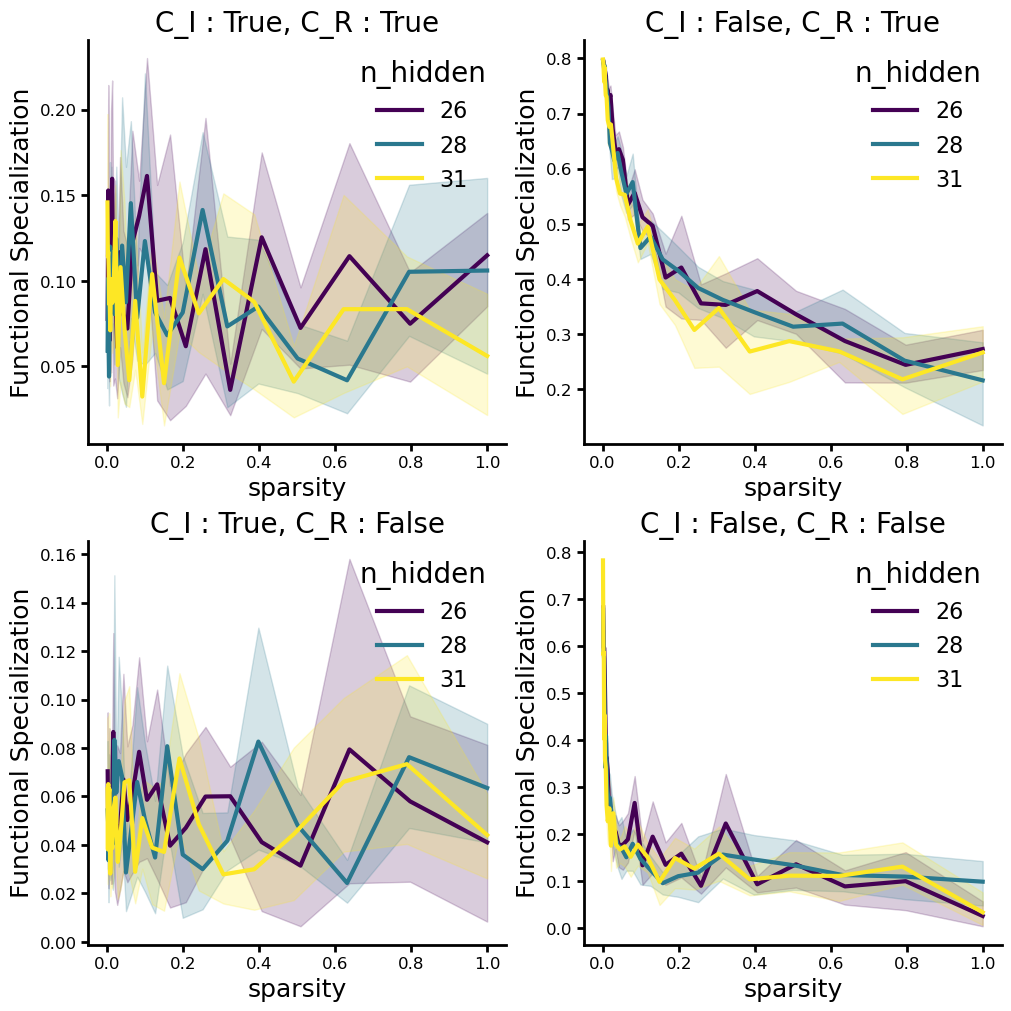

In [9]:
set_style()

smooth = False
get_mean = True

fig, axs = plt.subplots(2, 2, figsize=(10, 10), constrained_layout=True)

for ax, [c_r, c_i] in zip(axs.flatten(), product([True, False], repeat=2)):

    c_data = filter_data(
        total_data,
        {
            "Step": "last",
            "common_input": c_i,
            "common_readout": c_r,
            "n_bot": 5,
            "task": "parity-digits-both",
            'data_type' : 'double_digits',
            "n_hidden": uniques[10:13],
            "cov_ratio": 1.0,
        },
    )
    c_data = c_data[c_data["sparsity"] != 0]
    print(c_data.shape)

    metrics = [
        "retraining",
        #"correlations",
        #"ablations",
    ]

    names = ["Retraining", "Correlations", "Ablations"]

    # metrics = ['mean_global_diff']

    keys = [
        "metric_value",
        "metric_name",
        "sparsity",
        "n_hidden",
        "q_metric",
        "n_conns",
        #'nb_steps'
        # "s_index",
    ]
    plot_data = {k: [] for k in keys}
    smooth_data = {k: [] for k in keys[:2]}

    x = "sparsity"

    if 0 in c_data.shape:
        continue

    for metric, name in zip(metrics, names):
        plot_data["metric_value"].append(c_data[metric])
        plot_data["metric_name"].append(np.full(len(c_data), metric, dtype=object))

        if get_mean : 
            values = get_values(c_data.groupby(["n_hidden", x], as_index=False).mean(numeric_only=True), "n_hidden", x, metric)
        else :
            values = get_values(c_data, "n_hidden", x, metric)

        if smooth:

            ((X, Y), (X_mesh, Y_mesh), Z, sigmas, *_, cbar) = compute_and_plot_heatmap(
                values,
                (fig, ax),
                log_scale=False,
                plot_f=False,
                random=False,
                smoothness=0.5,
                minmax=None,
                cbar=False,
                plot=False,
            )

            smooth_data["metric_value"].append(Z.mean(1))
            smooth_data["metric_name"].append(np.full(len(Y), metric, dtype=object))
            smooth_data.setdefault(x, [])
            smooth_data[x].append(Y)

        for k in keys[2:]:
            try:
                plot_data[k].append(c_data[k])
            except KeyError:
                plot_data.pop(k)

    plot_data = pd.DataFrame.from_dict(
        {k: np.concatenate(v) for k, v in plot_data.items()}
    )

    if smooth:
        smooth_data = pd.DataFrame.from_dict(
            {k: np.concatenate(v) for k, v in smooth_data.items()}
        )

    sns.lineplot(
        data=smooth_data if smooth else plot_data,
        x=x,
        y="metric_value",
        hue="n_hidden",
        ax=ax,
        palette="viridis",
        estimator="mean",
    )

    # ax.set_yscale('log')
    ax.set_ylabel("Functional Specialization")
    ax.set_xlabel(x)

    ax.set_title(f"C_I : {c_i}, C_R : {c_r}")


(1680, 37)


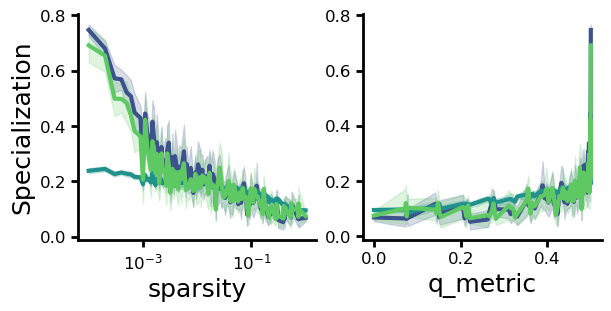

In [49]:
set_style()

smooth = False
get_mean = True
c_data = filter_data(
    total_data,
    {
        "Step": "last",
        "common_input": False,
        "common_readout": False,
        "n_bot": 5,
        "task": "parity-digits-both",
        # "n_hidden": uniques[10],
        "cov_ratio": 1,
    },
)
uniques = sorted(c_data["n_hidden"].unique().tolist())

c_data = c_data[c_data["sparsity"] != 0]
c_data = filter_data(c_data, {"n_hidden": uniques[-5:]})
print(c_data.shape)

metrics = [
    "retraining",
    "correlations",
    "ablations",
]

names = ["Retraining", "Correlations", "Ablations"]

# metrics = ['mean_global_diff']

keys = [
    "metric_value",
    "Metric",
    "sparsity",
    "n_hidden",
    "q_metric",
    "n_conns",
    "s_index",
]

fig, axs = plt.subplots(1, 2, figsize=(6, 3), constrained_layout=True)

# for m, (metric, axs_m, name) in enumerate(zip(metrics, [axs, axs, axs], names)) :

for i, (x, ax) in enumerate(zip(["sparsity", "q_metric"], axs)):

    plot_data = {k: [] for k in keys}
    smooth_data = {k: [] for k in keys[:2]}

    for metric, name in zip(metrics, names):
        plot_data["metric_value"].append(c_data[metric])
        plot_data["Metric"].append(np.full(len(c_data), name, dtype=object))

        if get_mean : 
            values = get_values(c_data.groupby(["n_hidden", x], as_index=False).mean(numeric_only=True), "n_hidden", x, metric)
        else :
            values = get_values(c_data, "n_hidden", x, metric)

        if smooth:

            ((X, Y), (X_mesh, Y_mesh), Z, sigmas, *_, cbar) = compute_and_plot_heatmap(
                values,
                (fig, ax),
                log_scale=False,
                plot_f=False,
                random=False,
                smoothness=[1, 2],
                minmax=None,
                cbar=False,
                plot=False,
            )

            smooth_data["metric_value"].append(Z.mean(1))
            smooth_data["Metric"].append(np.full(len(Y), name, dtype=object))
            smooth_data.setdefault(x, [])
            smooth_data[x].append(Y)

        for k in keys[2:]:
            plot_data[k].append(c_data[k])

    plot_data = pd.DataFrame.from_dict(
        {k: np.concatenate(v) for k, v in plot_data.items()}
    )

    if smooth:
        smooth_data = pd.DataFrame.from_dict(
            {k: np.concatenate(v) for k, v in smooth_data.items()}
        )

    sns.lineplot(
        data=smooth_data if smooth else plot_data,
        x=x,
        y="metric_value",
        hue="Metric",
        ax=ax,
        palette="viridis",
        estimator="mean",
    )

    if x == "sparsity":
        ax.set_xscale("log")

    if i != 0:
        ax.set_ylabel("")
    else:
        ax.set_ylabel("Specialization")

    ax.legend([])


In [26]:
uniques

[15]

In [26]:
len(sns.palettes.color_palette('pastel', 5))

5

(540, 38)


/tmp/ipykernel_3692/3183153705.py:118: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ticks_labels)
/tmp/ipykernel_3692/3183153705.py:118: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ticks_labels)
/tmp/ipykernel_3692/3183153705.py:118: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ticks_labels)


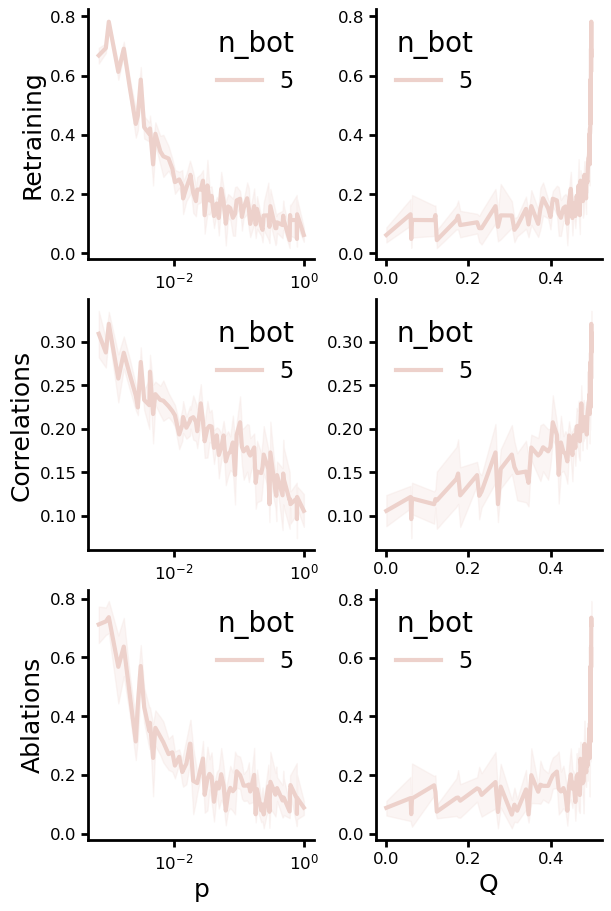

In [88]:
set_style()

smooth = False
get_mean = True

c_data = filter_data(
    total_data,
    {
        "Step": "last",
        "common_input": False,
        "common_readout": False,
        "n_bot": [None, 5],
        "task": "parity-digits-both",
        #"n_hidden": uniques[10:13],
        "cov_ratio": 1,
        'data_type' : 'double_digits'
    },
)
uniques = sorted(c_data["n_hidden"].unique().tolist())

c_data = c_data[c_data["sparsity"] != 0]
c_data = filter_data(c_data, {"n_hidden": uniques[12:15]})
print(c_data.shape)

metrics = [
    "retraining",
    "correlations",
    "ablations",
]

names = ["Retraining", "Correlations", "Ablations"]
palette = sns.palettes.color_palette('viridis', len(names))

#metrics = ['mean_global_diff']

keys = [
    "metric_value",
    "Metric",
    "sparsity",
    "n_hidden",
    "q_metric",
    "n_conns",
    "s_index",
    "q_index",
    'n_bot',
    #'nb_steps'
]

fig, axs = plt.subplots(3, 2, figsize=(3*2, 3*3), constrained_layout=True)

for m, (metric, axs_m, name, color) in enumerate(zip(metrics, axs, names, palette)) :
    try : 
        axs_m[0]
    except TypeError : 
        axs_m = np.array(axs_m)
    for i, (x, ax) in enumerate(zip(['sparsity', "q_metric"], axs_m)):

        plot_data = {k: [] for k in keys}
        smooth_data = {k: [] for k in keys[:2]}

        #for metric, name in zip(metrics, names):
        plot_data["metric_value"].append(c_data[metric])
        plot_data["Metric"].append(np.full(len(c_data), name, dtype=object))

        if get_mean : 
            values = get_values(c_data.groupby(["n_hidden", x], as_index=False).mean(numeric_only=True), "n_hidden", x, metric)
        else :
            values = get_values(c_data, "n_hidden", x, metric)

        if smooth:

            ((X, Y), (X_mesh, Y_mesh), Z, sigmas, *_, cbar) = compute_and_plot_heatmap(
                values,
                (fig, ax),
                log_scale=log_scale,
                plot_f=False,
                random=False,
                smoothness=[5, 10],
                minmax=None,
                cbar=m != 0,
                plot=False,
            )

            smooth_data["metric_value"].append(Z.mean(1))
            smooth_data["Metric"].append(np.full(len(Y), name, dtype=object))
            smooth_data.setdefault(x, [])
            smooth_data[x].append(Y)

        for k in keys[2:]:
            plot_data[k].append(c_data[k])

        plot_data = pd.DataFrame.from_dict(
            {k: np.concatenate(v) for k, v in plot_data.items()}
        )

        if smooth:
            smooth_data = pd.DataFrame.from_dict(
                {k: np.concatenate(v) for k, v in smooth_data.items()}
            )

        sns.lineplot(
            data=smooth_data if smooth else plot_data,
            x=x,
            y="metric_value",
            hue="n_bot",
            ax=ax,
            #palette="viridis",
            #color=color,
            estimator="mean",
        )

        if x == "sparsity":
            ax.set_xscale("log")
            ticks_labels = ax.get_xticklabels()
            ticks_labels[0] = 'None'
            ticks_labels[-1] = 'Full'
            #ticks_labels[1:-1] = ['' for _ in ticks_labels[1:-1]]
            ax.set_xticklabels(ticks_labels)

        if m != 2:
            ax.set_xlabel("")
            #ax.set_xticks([])
        else : 
            if x in ["sparsity", 's_index'] : 
                ax.set_xlabel('p')
            else : 
                ax.set_xlabel('Q')

        if i != 0:
            ax.set_ylabel("")
        else:
            ax.set_ylabel(name)
        
        #ax.legend()


In [87]:
c_data['n_bot']

2    None
2    None
2    None
2    None
2    None
     ... 
2    None
2    None
2    None
2    None
2    None
Name: n_bot, Length: 675, dtype: object

In [175]:
fig.savefig("../../results/imgs/metrics_6_bot.svg")

### Spec Gradient

In [153]:
def plot_spec_dynamics(ci=False, cr=False, n_hiddens_arg=[10], figax=None) : 
        

    c_data = filter_data(
        total_data,
        {
            "common_input": ci,
            "common_readout": cr,
            "n_bot": None,
            "task": "parity-digits-both",
            "cov_ratio": 1,
            # "n_hidden": [38, 42, 46],
            'data_type' : 'double_digits'
        },
    )
    uniques = sorted(c_data["n_hidden"].unique().tolist())

    c_data = c_data[c_data["sparsity"] != 0]
    c_data = c_data[c_data['best_acc'] > 0.75]
    c_data = filter_data(c_data, {"n_hidden": [uniques[n] for n in n_hiddens_arg]})

    print(c_data.shape)

    steps = c_data["Step"].unique().tolist()
    agents = ["0", "1", "all"]
    mul = [1, -1, 1]
    agents = [agents[0]] * len(steps) + [agents[-1]] + [agents[1]] * len(steps)
    mul = [mul[0]] * len(steps) + [mul[-1]] + [mul[1]] * len(steps)
    all_steps = steps + [steps[-1]] + steps[::-1]

    ts = np.arange(len(steps))
    ts = np.concatenate((ts, np.array([-1]), np.flip(ts)))
    ags = np.concatenate(
        (np.zeros(len(steps)), np.array([-1]), np.ones(len(steps)))
    ).astype(int)
    plot_data = {k: [] for k in ["x", "ag", "step", "metric", "sparsity", "n_conns"]}

    for x, (step, ag) in enumerate(zip(all_steps, agents)):

        metric = np.abs(c_data[c_data["Step"] == step][f"retraining_{ag}_local_diff"]) * mul[x]
        plot_data["x"].append(np.full_like(metric, x, dtype=int))
        plot_data["step"].append(np.full_like(metric, step, dtype=object))
        plot_data["ag"].append(np.full_like(metric, ag, dtype=object))
        plot_data["metric"].append(metric)
        plot_data["sparsity"].append(c_data[c_data["Step"] == step]["sparsity"])
        plot_data["n_conns"].append(c_data[c_data["Step"] == step]["n_conns"])

    plot_data = pd.DataFrame.from_dict({k: np.concatenate(v) for k, v in plot_data.items()})
    local_diffs = [
        c_data[c_data["Step"] == s][f"retraining_{ag}_local_diff"]
        for s, ag in zip(steps, ags)
    ]

    if figax is None : 
        fig, ax = plt.subplots(1, 1, figsize=(6, 3), constrained_layout=True)
    else : 
        fig, ax = figax


    sns.lineplot(
        plot_data, x="x", y="metric", hue="sparsity", palette="viridis", ax=ax, legend=False
    )
    x = plot_data["x"].unique()

    # steps_label = ["Start", "Comms", "Final"]
    steps_label = [f"t = {t}" for t in range(3)]
    x_labels = [f"{steps_label[t]}" for t in ts]
    x_labels[len(steps)] = "Readout"
    ax.set_xticks(x)
    ax.set_xticklabels(labels=x_labels)
    #ax.set_ylim(-1, 1)
    ax.set_ylabel("Specialization")
    #ax.set_yticks([-1, 0, 1], ["Full (1)", "None", "Full (0)"])
    ax.hlines(0, x[0], x[-1], linestyles="--", colors="black", alpha=0.1)
    #ax.vlines(x, -1, 1, linestyles="--", colors="black", alpha=0.1)
    #ax.fill_betweenx([-len(steps), len(steps)], 0, len(steps) - 1, alpha=0.5, label="M0")
    #ax.fill_betweenx(
    #    [-len(steps), len(steps)], len(steps) + 1, x[-1], alpha=0.5, label="M1"
    #)
    ax.set_xlabel("")
    ax.legend()

    sm = plt.cm.ScalarMappable(cmap="viridis")
    sm.set_array([])
    cb = fig.colorbar(sm, orientation="vertical", ax=ax)
    cb.set_label("p", fontsize="small")
    cb.set_ticks([0, 1], labels=["0", "Full"])


(1125, 36)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(840, 36)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(765, 36)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


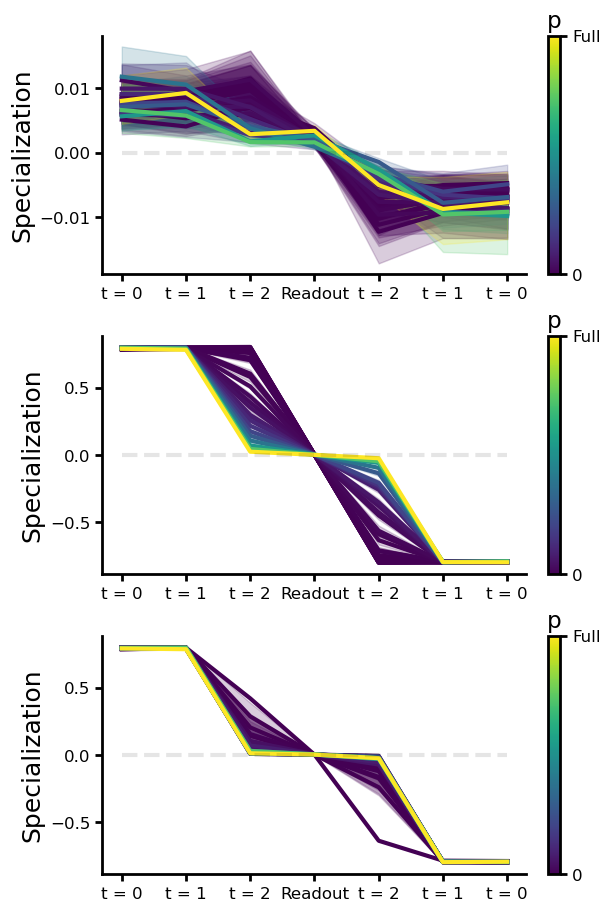

In [154]:
fig, axs = plt.subplots(3, 1, figsize=(6, 3*3), constrained_layout=True)

for ax, (ci, cr) in zip(axs.flatten(), [[True, True], [False, True], [False, False]]) : 
    plot_spec_dynamics(ci, cr, [-1], (fig, ax))

In [198]:
fig.savefig("../../results/imgs/gradient.svg")

### Parameter Importance

In [65]:
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz, plot_tree


In [259]:
params_rf = params + ["n_hidden", "sparsity"]

def get_feature_importance(
    fixed={"Step": "last", "n_bot": None, "data_type": "double_digits"}
):

    varying_params_rf = {}
    for param in params_rf:
        if param in total_data.columns:
            varying_params_rf[param] = total_data[param].unique().tolist()
            try:
                varying_params_rf[param] = sorted(varying_params_rf[param])
                varying_params_rf[param] = [
                    v if not np.isnan(v) else None for v in varying_params_rf[param]
                ]
            except TypeError:
                pass

    rf = RF()
    metric = metrics[0]
    # metric = "best_acc"

    all_features = [k for k, v in varying_params_rf.items() if len(v) > 1]

    fixed_features = {k: v for k, v in varying_params_rf.items() if len(v) == 1}
    fixed_features.update(fixed)

    data = total_data
    remaining_features = [f for f in all_features if f not in fixed_features]
    str_features = ["data_type", "task"]

    data = filter_data(data, fixed_features)

    X = data[remaining_features]
    y = data[metric]

    for feature in remaining_features:
        if feature in str_features:
            float_values = {u: k for k, u in enumerate(X[feature].unique())}
            X.replace({"data_type": float_values}, inplace=True)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

    rf.fit(X_train, y_train)

    #print(np.abs((rf.predict(X_test) - y_test)).mean())

    return {f: f_i for f, f_i in zip(rf.feature_names_in_, rf.feature_importances_)}

In [324]:
set_style()
from scipy.stats import pearsonr


def plot_feature_importance(feature_importances, ax=None, plot_corrs=True) : 
        
    if ax is None : 
        fig, ax = plt.subplots(figsize=(6, 3), constrained_layout=True)        

    plot_data = {}
    plot_data["feature"] = [k.replace("_", "\n") for k in feature_importances.keys()]
    plot_data["importance"] = list(feature_importances.values())
    plot_data['correlation'] = [pearsonr(X[f], y)[0] for f in feature_importances.keys()]
    plot_data = pd.DataFrame.from_dict(plot_data)
    plot_data['order'] = [plot_data['feature'].unique().tolist().index(f) for f in plot_data['feature']]
    plot_data['color'] = [sns.palettes.color_palette('pastel')[o] for o in plot_data['order']]

    plot_data.sort_values(by="importance", inplace=True)

    sns.barplot(
        plot_data,
        x="feature",
        y="importance",
        ax=ax,
        palette=plot_data['color'].unique(),
        #hue='feature',
        #order='order'
    )
    ax.set_xlabel("")
    ax.set_ylabel("Importance")


    arrow_colors = ['red', 'blue']
    if plot_corrs :
            
        #add arrows to plot
        for i, (feature, corr) in enumerate(plot_data['correlation'].items()):
            ax.arrow(i,        #x start point
                    0,                      #y start point
                    0,       #change in x 
                    corr,                      #change in y
                    head_width=0.2,         #arrow head width
                    head_length=0.1,        #arrow head length
                    width=0.05,              #arrow stem width
                    fc=arrow_colors[corr > 0],             #arrow fill color
                    ec=arrow_colors[corr > 0], 
                    label='' if i==0 else '', 
                    alpha=0.2)             #arrow edge color
            
        #ax.legend()

    return plot_data


In [307]:
plot_data = {k : [] for k in ['pathway', 'feature', 'importance', 'correlation']}
fixed={"Step": "last", "n_bot": None, "data_type": "double_digits"}

for (ci, cr), ax in zip(product([True, False], repeat=2), tqdm(axs.flatten()) ) : 
    fixed.update({'common_input' : ci, 'common_readout' : cr})
    f_i = get_feature_importance(fixed)
    plot_data["feature"].append([k.replace("_", "\n") for k in f_i.keys()])
    plot_data["importance"].append(list(f_i.values()))
    plot_data['correlation'].append([pearsonr(X[f], y)[0] for f in f_i.keys()])

    plot_data['pathway'].append([str((ci, cr))] * len(f_i))
    

  0%|          | 0/4 [00:00<?, ?it/s]

In [308]:
plot_data = {k : np.concatenate(v) for k, v in plot_data.items()}

In [309]:
pd_data = pd.DataFrame.from_dict(plot_data)

Text(0, 0.5, 'Feature Importance')

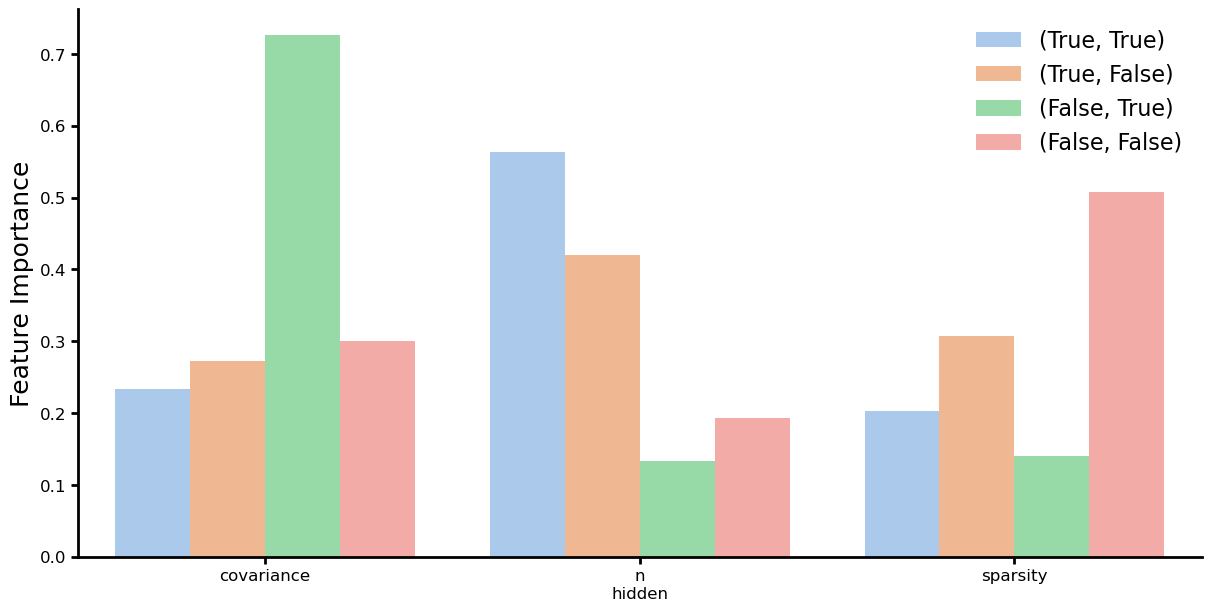

In [310]:
fig, ax = plt.subplots(figsize=(12, 6), constrained_layout=True)        

sns.barplot(
    plot_data,
    x="feature",
    y="importance",
    ax=ax,
    palette="pastel",
    hue='pathway',
    #order=['n_hidden', 'sparsity', 'covariance']
)
ax.set_xlabel("")
ax.set_ylabel("Feature Importance")

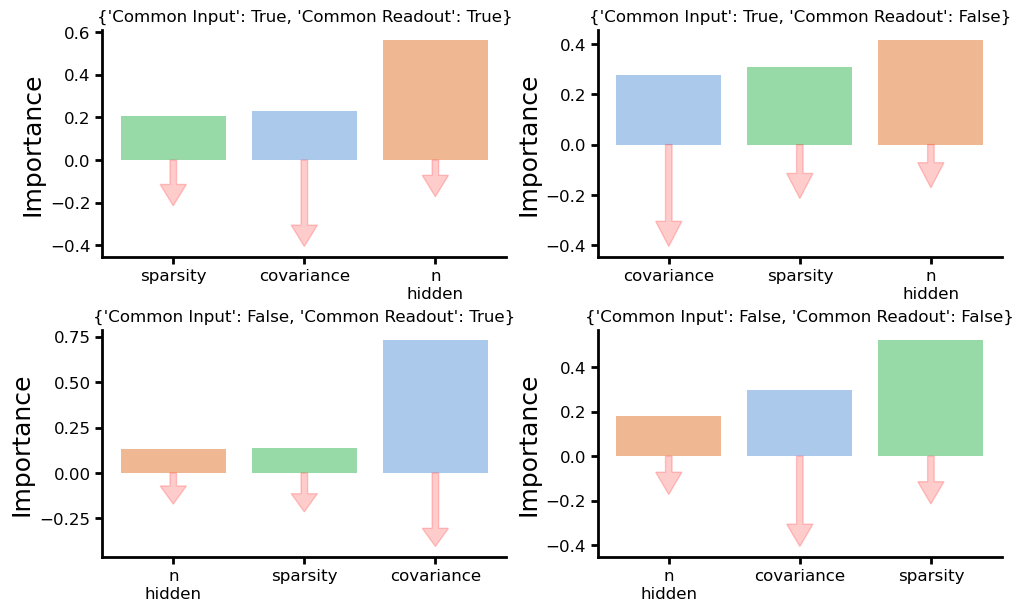

In [325]:
fixed={"Step": "last", "n_bot": None, "data_type": "double_digits"}
fig, axs = plt.subplots(2, 2, figsize=(10, 6), constrained_layout=True)
for (ci, cr), ax in zip(product([True, False], repeat=2), axs.flatten()) : 
    fixed.update({'common_input' : ci, 'common_readout' : cr})
    plot_data = plot_feature_importance(get_feature_importance(fixed), ax)
    ax.set_title({'Common Input' : ci, 'Common Readout' : cr}, fontsize=12)

In [326]:
fig.savefig("../../results/imgs/feature_importance.svg")

## Tables

In [142]:
y_values_per_x


n_hidden
10          [1.0, 0.75, 0.5, 0.25]
25          [1.0, 0.75, 0.5, 0.25]
50          [1.0, 0.75, 0.5, 0.25]
75     [1.0, 0.75, 0.5, 0.25, 0.0]
100    [1.0, 0.75, 0.5, 0.25, 0.0]
Name: cov_ratio, dtype: object

### Specialization Gradient

In [15]:
def get_spec_gradient(**v_params):

    if v_params["n_hidden"] not in total_data["n_hidden"].unique():
        return

    v_params.pop("Step")
    print(v_params)
    ags = ["Ag 0", "Readout", "Ag 1"]
    data = filter_data(total_data, v_params)
    data_per_ts = [filter_data(data, {"Step": ts}) for ts in ["mid-", "last"]]
    data_per_ag_mean = [
        [data[[f"bottleneck_{ag}_local_diff"]] for ag in [0, "all", 1]]
        for data in data_per_ts
    ]

    diffs_ag_ts = {
        f"{ags[j]} ts {i}": data_per_ag_mean[i][j].values.squeeze()
        for i, j in [[0, 0], [1, 0], [1, 1], [1, 2], [0, 2]]
    }

    diffs_ag_ts = pd.DataFrame.from_dict(diffs_ag_ts)
    diffs_ag_ts["sparsity"] = data_per_ts[0]["sparsity"].values.squeeze()

    fig, ax = plt.subplots(figsize=(10, 5), dpi=100, constrained_layout=True)
    plot_data = data = diffs_ag_ts.groupby("sparsity").mean()
    colors = sns.color_palette(
        "husl", n_colors=len(plot_data.index.values)
    )  # get a number of colors
    cmap = dict(zip(plot_data.index.values, colors))  # zip values to colors
    plot = sns.lineplot(plot_data.T, legend=False, palette=cmap, ax=ax)

    sm = plt.cm.ScalarMappable(cmap=sns.husl_palette(as_cmap=True))
    sm.set_array([])
    fig.colorbar(sm, label="% interconnections", orientation="vertical", ax=ax)

    ax.set_xticklabels(
        [
            f"{ 'Ag' * (ag != 'Readout')} {ag} Step {t}"
            for t, ag in [[0, 0], [1, 0], [1, "Readout"], [1, 1], [0, 1]]
        ]
    )
    ax.set_ylim(-1, 1)
    ax.set_ylabel("Functional \n Specialization")
    ax.set_yticks([-1, 0, 1], ["Subtask 1", "No Spec", "Subtask 0"])

    ax.hlines(0, 0, 4, linestyles="--", colors="black", alpha=0.3)
    ax.vlines(np.arange(5), -1, 1, linestyles="--", colors="black", alpha=0.3)

    fig.show()


In [16]:
params_widgets = {
    k: widgets.Select(
        options=[p for p in params], description=k, disabled=False, value=params[0]
    )
    for k, params in varying_params.items()
}

params_widgets["n_hidden"] = widgets.IntSlider(value=25, min=10, max=100, step=5)

interactive_plot = widgets.interactive(get_spec_gradient, **params_widgets)

display(interactive_plot)


interactive(children=(Select(description='common_readout', options=(True,), value=True), Select(description='n…

In [230]:
{params[0] for k, params in varying_params.items()}


{5, False, True, 'mid-', 'parity-digits'}

### Parameter Importance

In [102]:
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz, plot_tree


In [104]:
params_rf = params + ['n_hidden', 'sparsity']

varying_params_rf = {}
for param in params:
    if param in total_data.columns:
        varying_params_rf[param] = total_data[param].unique().tolist()
        try:
            varying_params_rf[param] = sorted(varying_params_rf[param])
            varying_params_rf[param] = [
                v if not np.isnan(v) else None for v in varying_params_rf[param]
            ]
        except TypeError:
            pass

rf = RF()
metric = metrics[0]
# metric = "best_acc"

all_features = [k for k, v in varying_params_rf.items() if len(v) > 1]

fixed_features = {k: v for k, v in varying_params_rf.items() if len(v) == 1}

fixed_features.update({"Step": "last", "n_bot": None, 'cov_ratio' : 1})

data = total_data
remaining_features = [f for f in all_features if f not in fixed_features]

data = filter_data(data, fixed_features)

X = data[remaining_features]
y = data[metric]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

rf.fit(X_train, y_train)

print(np.abs((rf.predict(X_test) - y_test)).mean())

feature_importances = lambda rf: {
    f: f_i for f, f_i in zip(rf.feature_names_in_, rf.feature_importances_)
}

ValueError: could not convert string to float: 'double_digits'

In [105]:
varying_params_rf

{'data_type': ['double_digits', 'double_letters'],
 'task': ['parity-digits-both'],
 'common_readout': [False, True],
 'common_input': [False, True],
 'n_bot': [None, 5],
 'cov_ratio': [0.01, 0.02, 0.03, 0.05, 0.08, 0.13, 0.22, 0.36, 0.6, 1.0],
 'Step': ['0', 'last', 'mid-']}

In [150]:
feature_importances(rf)


{'common_readout': 0.08835830398627519,
 'common_input': 0.11556805494836744,
 'cov_ratio': 0.24013192899714103,
 'n_hidden': 0.10968919700068862,
 'sparsity': 0.4462525150675277}

Text(0, 0.5, 'Feature Importance')

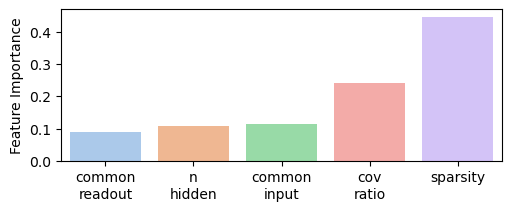

In [174]:
plot_data = {}
plot_data["feature"] = [k.replace("_", "\n") for k in feature_importances(rf).keys()]
plot_data["importance"] = list(feature_importances(rf).values())
plot_data = pd.DataFrame.from_dict(plot_data)

fig, ax = plt.subplots(figsize=(5, 2), constrained_layout=True)
sns.barplot(
    plot_data.sort_values(by="importance"),
    x="feature",
    y="importance",
    ax=ax,
    palette="pastel",
)
ax.set_xlabel("")
ax.set_ylabel("Feature Importance")

In [176]:
5


2.5

In [175]:
fig.savefig("../../results/imgs/feature_importance.svg")

In [2]:
import numpy as np
import numpy.linalg as LA
from numpy.linalg import LinAlgError

In [8]:
def agent_diff(col):
    return (col[1] - col[0]) / col.sum()


def global_diff(M):
    return np.abs(agent_diff(M[:, 0]) - agent_diff(M[:, 1])) / 2


def new_metric(M):
    return np.abs(LA.det(M)) / M.sum(0).prod()


In [29]:
n_agents = 2

M = np.random.rand(n_agents, n_agents)

M = np.eye(n_agents)
M[0, 1] = 1

new_metric(M), np.abs(LA.det(M))

(0.5, 1.0)

In [128]:
idxs = [0, 2]
sub_mat = lambda M, idx: np.delete(np.delete(M, idx[0], 0), idx[1], 1).squeeze()
sub_mat(M, idxs), M


(array([[0., 1.],
        [0., 0.]]),
 array([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]]))

In [180]:
def reccursive_new_metric(M):
    if M.shape[0] > 2:

        res = new_metric(M)

        for i in range(M.shape[0]):
            for j in range(M.shape[1]):
                subM = sub_mat(M, [i, j])
                res += reccursive_new_metric(subM)

    else:
        res = new_metric(M)

    print(res)
    return res
